# K-Nearest Neighbors (Classification)

This notebook implements the constructed k-nearest neighbors (KNN) classification algorithm on a ***TODO: FINISH THIS***. For a more comprehensive overview of the ***way the algorithm works***, see the associated README ***link this here***.

**sections i want: library imports, data loading/explanation, visualization of data, knn with 2 features and visualization, knn with multiple features, accuracy across different values of k, then different metrics, comparison with scikit learn for metrics**

### Library Imports
This section imports the libraries **and modules** required to run the KNN algorithm. The **following dependencies are required**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.knn import *
from rice_ml.postprocess.classificationpost import *

### Data Loading & Cleaning
The data used in this notebook comes from Palmer Penguins, a common toy dataset for evaluating classification algorithms due to its **clear-cut features/simplicity/not too large/other benefits**. It has been chosen **because it is simple for classification** and requires several preprocessing steps, including **handling missing values**, which **showcase the preprocessing modules/package**. This dataset contains the following feature data for 344 penguins:
- Species: **fill this in, three species - 'Adelie' 'Chinstrap' 'Gentoo'**
- Island: **fill this in - 'Biscoe' 'Dream' 'Torgersen'**
- Bill Length (mm): continuous values, measuring bill length in millimeters
- Bill Depth (mm): continuous values, measuring bill depth in millimeters
- Flipper Length (mm): continuous values, measuring flipper length in millimeters
- Body Mass (g): continuous values, measuring body mass in grams
- Sex: **binary male/female**

**we drop some features** 
**This section covers the actual loading of the data; the data is loaded using `sns.load_dataset("penguins")`. Explanation here!! why those features?? encode using pandas uniques. Then cleaned using preprocessing - dropped missing values, identified outliers with z-scoring and dropped, dropped duplicates, z-scored the feature data for standardization**. This **notebook attempts to predict species**

In [2]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "species", 
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]
penguin_features.loc[:, 'species'], uniques = pd.factorize(penguin_features['species'])
display(penguin_features)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0,39.1,18.7,181.0,3750.0
1,0,39.5,17.4,186.0,3800.0
2,0,40.3,18.0,195.0,3250.0
3,0,NaN,NaN,NaN,NaN
4,0,36.7,19.3,193.0,3450.0
...,...,...,...,...,...
339,2,NaN,NaN,NaN,NaN
340,2,46.8,14.3,215.0,4850.0
341,2,50.4,15.7,222.0,5750.0
342,2,45.2,14.8,212.0,5200.0


The dataset contains **some missing values (e.g., row 4)** and **may contain outliers or duplicates**. To **put the data in a usable format**, we apply a series of preprocessing **algorithms**, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [3]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[   0.    39.1   18.7  181.  3750. ]
 [   0.    39.5   17.4  186.  3800. ]
 [   0.    40.3   18.   195.  3250. ]
 [   0.    36.7   19.3  193.  3450. ]
 [   0.    39.3   20.6  190.  3650. ]]


Two rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in KNN classification and **for ease of visualization**, the dataset must be split into the target feature (species) and the remaining **features**.

In [4]:
# Creating two arrays
penguin_species = penguin_features_cleaned[:, 0]
penguin_feature_data = penguin_features_cleaned[:, 1:]
print(f"Array for penguin species (first five entries): \n {penguin_species[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for penguin species (first five entries): 
 [0. 0. 0. 0. 0.] 
 
 Array for penguin feature data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


### Data Visualization

**Once the data has been cleaned, this section contains version of visualizing data (correlations, plotting two features for classification). for KNN with two features, we will use bill_length_mm	and bill_depth_mm.** **the first step is using the correlation matrix to be able to see what features may be** appropriate for classifying species type.

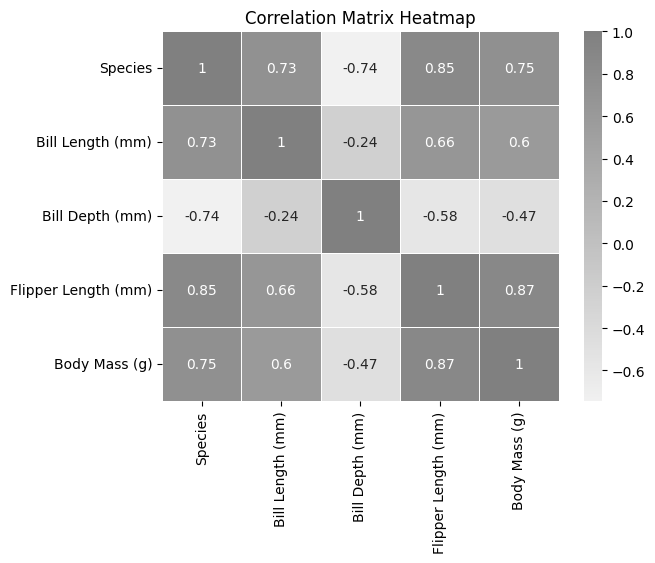

In [5]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Species', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap = sns.light_palette('gray', as_cmap=True), linewidths = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Both bill length and bill depth appear to be correlated with species (0.73 and -0.74, respectively), while they are not **particularly correlated with each other** (-0.24). Consequently, these features are **appropriate for KNN and we will use these moving forward until [the later section]**. To visualize the relationship between the three variables and **identify possible clusters**, we create a 2D plot of bill depth versus bill length, with colors indicating species.

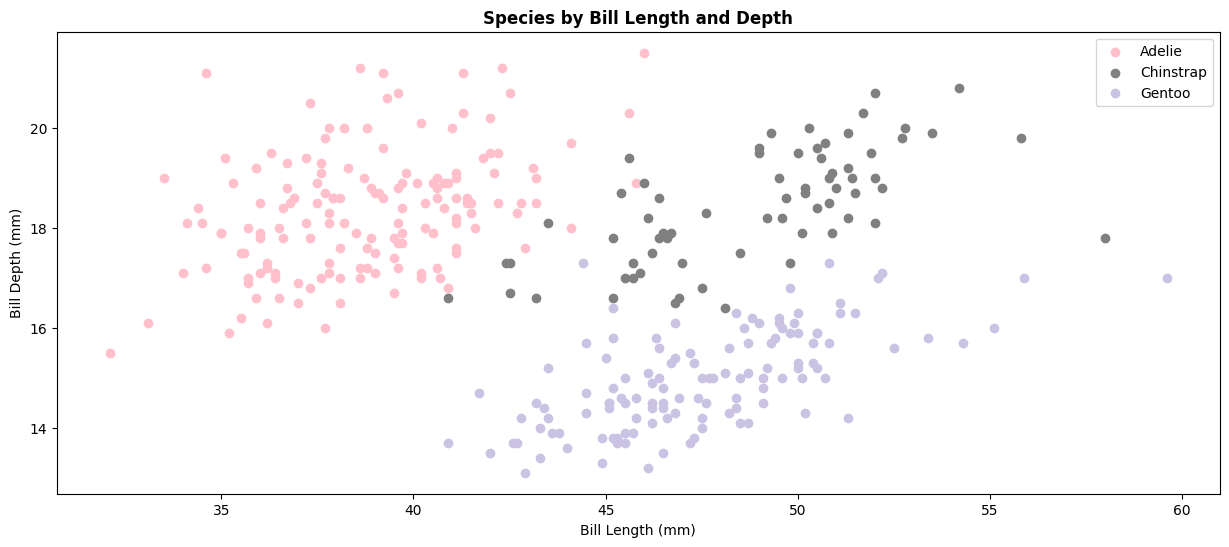

In [6]:
# Plotting bill length and bill depth, color-coded by species
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}

plt.figure(figsize = (15, 6))
for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    plt.scatter(penguin_feature_data[mask, 0], penguin_feature_data[mask, 1], label = species, color = colors[species])
    
plt.legend(['Adelie', 'Chinstrap', 'Gentoo'])
plt.title("Species by Bill Length and Depth", fontweight = 'bold')
plt.xlabel("Bill Length (mm)")
plt.ylabel("Bill Depth (mm)")

plt.show()

Three fairly distinct clusters corresponding to different species appear **from this plot**, **meaning that we can use this for KNN. elaborate!!**

### KNN Implementation (2 Features)

This section **implements a basic KNN algorithm for the two identified features to attempt to classify species**. **elaborate!!** 

**To avoid skewing results with different feature values**, we standardize the feature data **by calculating zscores** using the `z_score_standardize` **module** from the preprocessing package. This ensures that **no feature dominates/overrides the other ones** by **making them all the same scale**. The z-score equation used is **this!!**

In [7]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [0, 1]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923]
 [-0.81112573  0.1261879 ]
 [-0.66437972  0.43046236]
 [-1.32473679  1.08972369]
 [-0.84781224  1.74898502]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. **stratification/0.3 test_array size**. There are 342 samples in **the cleaned dataset**, so the training array should have 240 samples and the testing should have 102.

In [8]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, penguin_species, stratify = penguin_species)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (240, 2)
Shape of training targets: (240,)
Shape of testing array: (102, 2)
Shape of testing targets: (102,)


**Next, we apply KNN by initializing a `knn_classification` class from the supervised learning package, and fitting it on the training data**. The test feature data is then **fed into** the fit model to predict species labels **from previously unseen data**. **This model uses 3 neighbors and euclidean distance, although these parameters are variable (see section below)**.

In [9]:
# Fitting the model
knn = knn_classification()
knn.fit(train_array, train_targets)

# Predicting species based on testing data
prediction = knn.prediction(test_array)

**When the model has been successfully called/fit, we calculate a variety of postprocessing/accuracy/scoring metrics using the postprocessing package**. These include **accuracy, a visualization of the confusion matrix, and precision/recall/f1 scores for each one**. **fix this!! plot with the scores**. The **plot below shows the classification for the test cases plotted against the correct labels for the entire dataset; the rightmost plot contains the same plots/labels, but with the incorrectly classified points labeled in yellow.**

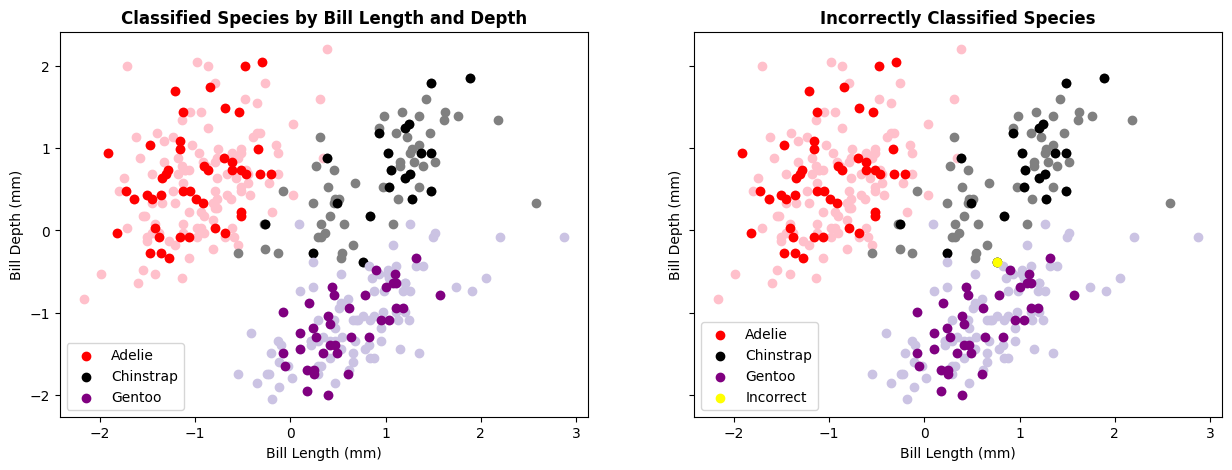

In [10]:
# Plotting bill length and bill depth, color-coded by species
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}
colors_2 = {0: 'red', 1: 'black', 2: 'purple'}

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharex = True, sharey = True)

for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    ax[0].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
    ax[1].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
    mask_new = (test_targets == species)
    ax[0].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = species, color = colors_2[species])
    ax[1].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = species, color = colors_2[species])

mask_incorrect = (test_targets != prediction)
ax[1].scatter(test_array[mask_incorrect, 0], test_array[mask_incorrect, 1], label = species, color = 'yellow')

handles, labels = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in [1, 3, 5]]
selected_handles_2 = [handles[i] for i in [1, 3, 5, 6]]
ax[0].legend(handles = selected_handles, labels = ['Adelie', 'Chinstrap', 'Gentoo'])
ax[1].legend(handles = selected_handles_2, labels = ['Adelie', 'Chinstrap', 'Gentoo', 'Incorrect'])

ax[0].set_title("Classified Species by Bill Length and Depth", fontweight = 'bold')
ax[1].set_title("Incorrectly Classified Species", fontweight = 'bold')

for i in range(2):
    ax[i].set_xlabel("Bill Length (mm)")
    ax[i].set_ylabel("Bill Depth (mm)")

plt.show()

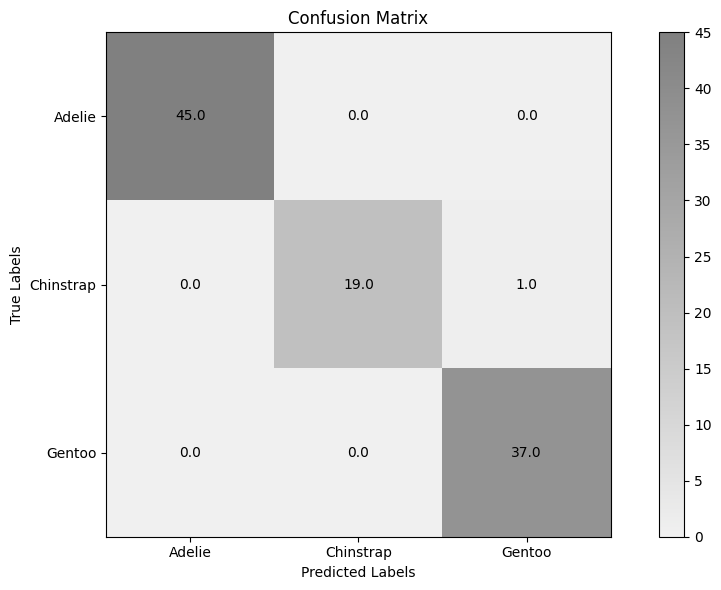

In [11]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction, test_targets, conf_matrix_labels = ['Adelie', 'Chinstrap', 'Gentoo'])

In [12]:
# Evaluating model performance on various metrics
print_model_metrics(prediction, test_targets)

Model Metrics 
------------- 
Accuracy: 0.99 
Precision (Micro): 0.99 
Precision (Macro): 0.99 
Recall (Micro): 0.99 
Recall (Macro): 0.98 
F1 (Micro): 0.99 
F1 (Macro): 0.99


**explain the model metrics here!!**

### KNN Implementation (Changing Parameters)

This section **implements a basic KNN algorithm for the two identified features to attempt to classify species**, but **with different types of parameters. It first determines the accuracy for various values of k using Euclidean distance, then for different distance metrics with the ideal k.**

**the first part looks at accuracy for different values of k as an evaluation for which is the best k; the second looks at distance, the third at weighting**

In [13]:
# Arrays for k-values and accuracy
k_values = np.arange(1, 16)
accuracy_values_k = np.full(len(k_values), np.nan)

# Fitting and scoring the model for each value of k
for i in range(len(k_values)):
    knn = knn_classification(k = k_values[i])
    knn.fit(train_array, train_targets)
    accuracy = knn.scoring(test_array, test_targets)
    accuracy_values_k[i] = accuracy

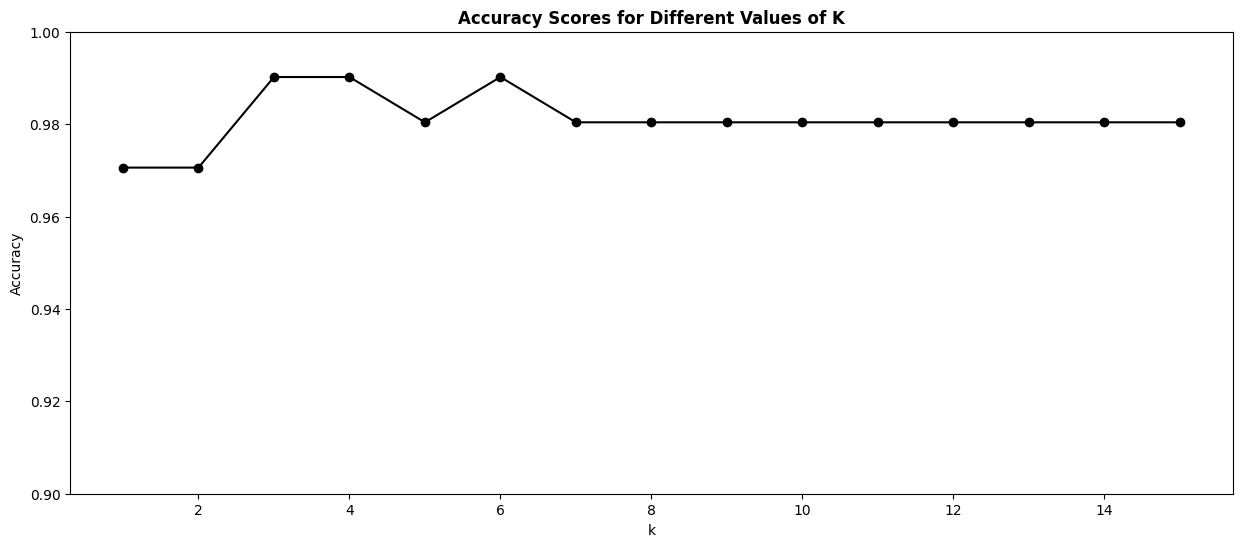

In [14]:
# Plotting the change in accuracy across different k-values
plt.figure(figsize = (15, 6))
plt.plot(k_values, accuracy_values_k, 'black')
plt.scatter(k_values, accuracy_values_k, color = 'black')
plt.title("Accuracy Scores for Different Values of K", fontweight = 'bold')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1)
plt.show()

**The accuracy is high for many values of k, but varies as k increases. Generally, it is highest with k = 3 to k = 5, and decreases/tapers off/plateaus afterwards. It is lower for k = 1 and 2, but with some variation based on model performance**. Given the results of the graph, **we will use k = 3 for the remainder of the analysis.**

In [15]:
# Arrays for distance type and accuracy
dist_type = ['euclidean', 'manhattan', 'minkowski', 'minkowski', 'minkowski']
accuracy_values_dist = np.full(5, np.nan)

# Fitting and scoring the model for different distance metrics
for i in range(len(dist_type)):
    knn = knn_classification(k = 3, metric = dist_type[i], p = i + 1)
    knn.fit(train_array, train_targets)
    accuracy = knn.scoring(test_array, test_targets)
    accuracy_values_dist[i] = accuracy

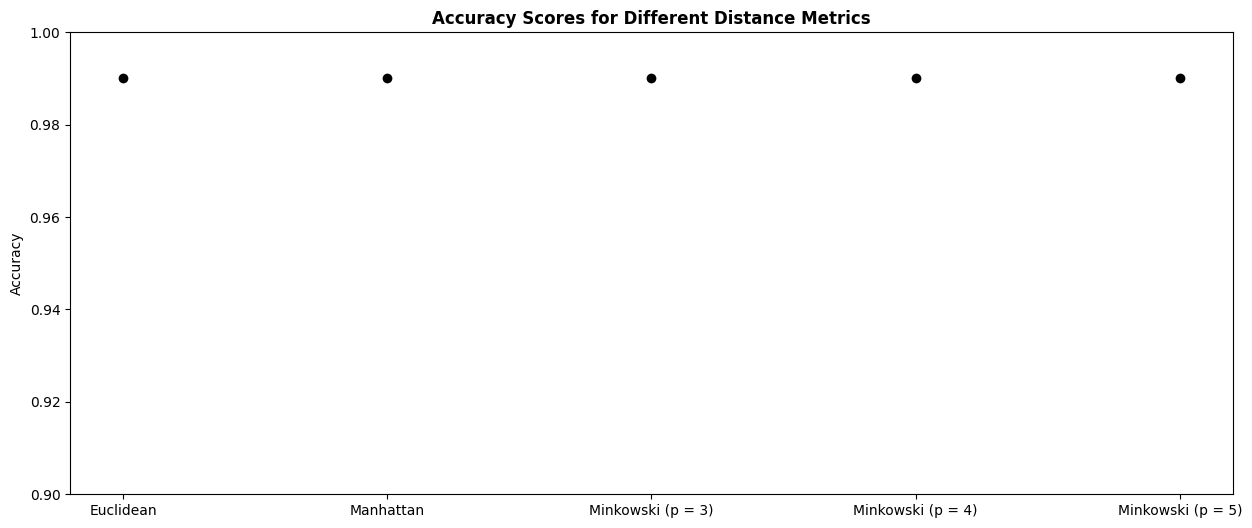

In [16]:
# Plotting the change in accuracy across different k-values
plt.figure(figsize = (15, 6))
plt.scatter(["Euclidean", "Manhattan", "Minkowski (p = 3)", "Minkowski (p = 4)", "Minkowski (p = 5)"], accuracy_values_dist, color = 'black')
plt.title("Accuracy Scores for Different Distance Metrics", fontweight = 'bold')
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.show()

**the distance metrics indicate that generally they are the same, although with some distinctions - elaborate!! TODO**

In [17]:
# Arrays for weighting type and accuracy
weights = ['uniform', 'distance']
accuracy_values_weights = np.full(len(weights), np.nan)

# Fitting and scoring the model for different weights metrics
for i in range(len(weights)):
    knn = knn_classification(k = 3, metric = 'euclidean', weight = weights[i])
    knn.fit(train_array, train_targets)
    accuracy = knn.scoring(test_array, test_targets)
    accuracy_values_weights[i] = accuracy

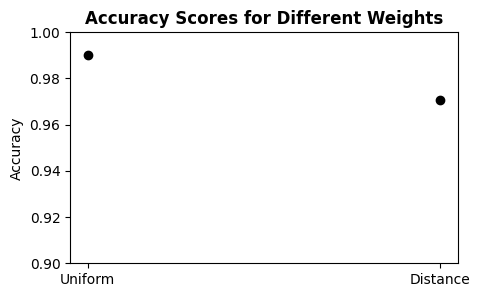

In [18]:
# Plotting the change in accuracy across different weighting types
plt.figure(figsize = (5, 3))
plt.scatter(["Uniform", "Distance"], accuracy_values_weights, color = 'black')
plt.title("Accuracy Scores for Different Weights", fontweight = 'bold')
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.show()

**weighting is also similar, so interchangeable - TODO**

### KNN Implementation (Multiple Features)

**this section implements KNN in the same way using multiple features to see if it improves model accuracy/works**. As before, we begin by standardizing all features and splitting the data into training and test sets, then **initializing/fitting a model**

In [19]:
# Standardizing the features
penguin_feature_data_normal_all_feat = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal_all_feat[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923 -1.41834665 -0.56414208]
 [-0.81112573  0.1261879  -1.06225022 -0.50170305]
 [-0.66437972  0.43046236 -0.42127665 -1.18853234]
 [-1.32473679  1.08972369 -0.56371522 -0.93877623]
 [-0.84781224  1.74898502 -0.77737308 -0.68902013]]


In [20]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_normal_all_feat, penguin_species, stratify = penguin_species)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (240, 4)
Shape of training targets: (240,)
Shape of testing array: (102, 4)
Shape of testing targets: (102,)


In [21]:
# Fitting the model
knn_mult = knn_classification()
knn_mult.fit(train_array_mult, train_targets_mult)

# Predicting species based on testing data
prediction_mult = knn_mult.prediction(test_array_mult)

Because the model **classified based on four features, there is no way to easily visualize the clusters in a four-dimensional space**. Instead, model evaluation takes place using the confusion matrix and various performance metrics.

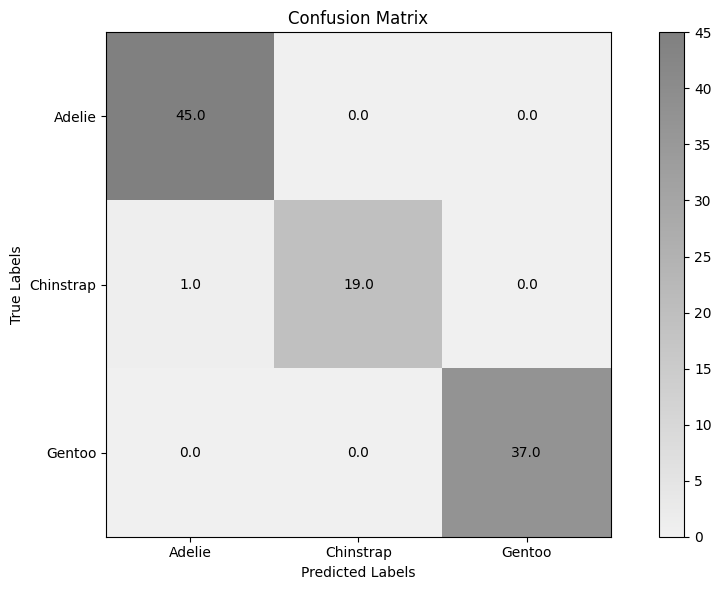

In [22]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction_mult, test_targets_mult, conf_matrix_labels = ['Adelie', 'Chinstrap', 'Gentoo'])

In [23]:
# Evaluating model performance on various metrics
print_model_metrics(prediction_mult, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 0.99 
Precision (Micro): 0.99 
Precision (Macro): 0.99 
Recall (Micro): 0.99 
Recall (Macro): 0.98 
F1 (Micro): 0.99 
F1 (Macro): 0.99


This model has slightly better **accuracy/other metrics** than that containing only two features; consequently, **the inclusion of more of these features leads to better classification of species type**. Only **one was mislabeled - explain confusion matrix!!** However, the **model only including two features had good performance as well, indicating that this dataset is suitable for classification with only two/the KNN model is able to run even with two features**

### Comparison with Existing Models

**This section compares this KNN classifier, which was built in the supervised learning package**, with the **established models using SciKit Learn**. It **evaluates the model accuracy on the entire dataset using the same k and same distance metrics to determine which is a better fit/if both are good, since SciKit Learn is the gold standard/well-established**

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn_sk = KNeighborsClassifier(n_neighbors = 3, metric = 'euclidean')
knn_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = knn_sk.predict(test_array_mult)

In [25]:
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 0.99 
Precision (Micro): 0.99 
Precision (Macro): 0.99 
Recall (Micro): 0.99 
Recall (Macro): 0.98 
F1 (Micro): 0.99 
F1 (Macro): 0.99


The **established sklearn KNN classifier has accuracy, precision, recall, and F1 scores similar to that of the constructed class/model**. Thus, this **test verifies this version of KNN as sufficient for classification**